# 실행

In [1]:
from final_functions.final_transformer import *

In [2]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

# Hyper Parameter
input_window = 100
output_window = 60
epochs = 150
batch_size = 512

# Dataset 불러오기
df_DL = time_series_dataframe()
df_DL_temp = df_DL['TEMP'].values
df_DL_label = df_DL['label'].values

train_len = int(len(df_DL) * 0.7)
train_data = df_DL_temp[:train_len]
test_data = df_DL_temp[train_len:]
train_label = df_DL_label[:train_len]
test_label = df_DL_label[train_len:]


train_data = scaler_train.fit_transform(train_data.reshape(-1,1)).reshape(-1)
test_data = scaler_test.fit_transform(test_data.reshape(-1,1)).reshape(-1)

train_data, _ = multistep_time_series(train_data, train_label, input_window, output_window)
test_data, test_label = multistep_time_series(test_data, test_label, input_window, output_window)

# X_train = train_data[:, 0, :].reshape((-1,input_window, 1))
# y_train = train_data[:, 1, :].reshape((-1,input_window, 1))
# X_test = test_data[:, 0, :].reshape((-1,input_window, 1))
# y_test = test_data[:, 1, :].reshape((-1,input_window, 1))


# PyTorch 돌리기위한 설정
lr = 0.001
device = 'cuda' if torch.cuda.is_available else 'cpu' 
model = TransAm().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

# train_dataset = TimeSeiresDataset(X_train, y_train, input_window)
# test_dataset = TimeSeiresDataset(X_test, y_test, input_window)
# train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
# test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
train_data = train_data.to(device)
test_data = test_data.to(device)

| epoch   1 |   181/  908 batches | lr 0.001000 | 55.19 ms | loss 0.02333 | ppl     1.02
| epoch   1 |   362/  908 batches | lr 0.001000 | 52.90 ms | loss 0.00172 | ppl     1.00
| epoch   1 |   543/  908 batches | lr 0.001000 | 52.70 ms | loss 0.00087 | ppl     1.00
| epoch   1 |   724/  908 batches | lr 0.001000 | 52.80 ms | loss 0.00084 | ppl     1.00
| epoch   1 |   905/  908 batches | lr 0.001000 | 53.35 ms | loss 0.00116 | ppl     1.00


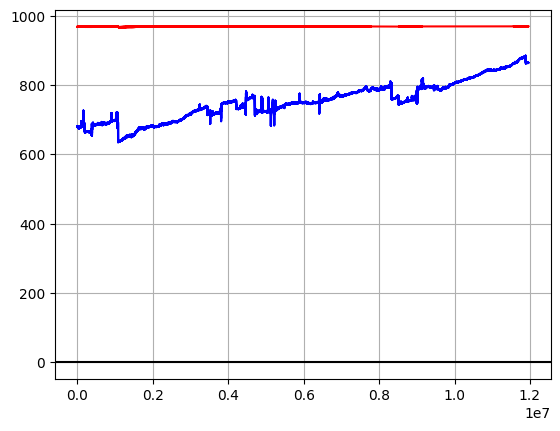

---------------------------------------------------------------------------
| end of epoch   1 | time: 895.13s | valid loss 0.79595 | valid ppl     2.22 |
---------------------------------------------------------------------------
| epoch   2 |   181/  908 batches | lr 0.000960 | 54.55 ms | loss 0.03245 | ppl     1.03
| epoch   2 |   362/  908 batches | lr 0.000960 | 52.81 ms | loss 0.00166 | ppl     1.00
| epoch   2 |   543/  908 batches | lr 0.000960 | 52.63 ms | loss 0.00107 | ppl     1.00
| epoch   2 |   724/  908 batches | lr 0.000960 | 52.80 ms | loss 0.00078 | ppl     1.00
| epoch   2 |   905/  908 batches | lr 0.000960 | 52.90 ms | loss 0.00122 | ppl     1.00


KeyboardInterrupt: 

In [4]:
best_val_loss = float("inf")
best_model = None

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_tmp(model, train_data,batch_size, optimizer, criterion, input_window, output_window, epoch, scheduler)
    
    if (epoch % 1 == 0):
        truth, test_result, result_to_ML, val_loss = plot_and_loss(model, test_data, criterion,input_window, output_window, scaler_test)
    else:
        val_loss = evaluate2(model, test_data,criterion, input_window,output_window, input_window)
    
    print('-' * 75)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f} |'.format(epoch, (time.time() - start_time),
                                        val_loss, math.exp(val_loss)))
    print('-' * 75)
    
    scheduler.step()

# ML

### Train

In [ ]:
from final_functions.final_ML import time_series_dataframe_ML

df_ts_ML, _, _ = time_series_dataframe_ML()

In [1]:
from final_functions.final_ML import ML, make_dataframe
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df_ML = make_dataframe(60,1)
X = df_ML.iloc[:, :9].values
y = df_ML['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, shuffle = True)



In [ ]:
params = { 'n_estimators' : [10,20,50,100],
           'max_depth' : [10,20,30,40,50,60],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 42, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [ ]:
ML_model, ML_accuracy = ML()
print(ML_accuracy)

### Transformer output to DataFrame

In [ ]:
from scipy.stats import skew, kurtosis

columns = {'MEAN_TEMP' : [], 'STD' : [], 'MIN' : [], 'MAX' : [], 'SKEW' : [], 'KURT' : [], 'MEDIAN':[], '25%' : [], '75%' : []} #, 'label' : []
for LIST in result_to_ML:
    
    MEAN = np.round(np.mean(LIST), 3)
    MIN = np.min(LIST)
    MAX = np.max(LIST)
    STD = np.std(LIST)
    median = np.median(LIST)
    SKEW = skew(LIST)
    KURT = kurtosis(LIST)
    a, b = np.percentile(LIST, q = [25,75])
    
    #columns['label'].append(i)
    columns['MEAN_TEMP'].append(MEAN)
    columns['MIN'].append(MIN)
    columns['MAX'].append(MAX)
    columns['STD'].append(STD)
    columns['SKEW'].append(SKEW)
    columns['KURT'].append(KURT)
    columns['MEDIAN'].append(np.round(median,3))
    columns['25%'].append(np.round(a,3))
    columns['75%'].append(np.round(b,3))

LABEL = pd.DataFrame({'label' : test_label})

dataframe = pd.DataFrame(columns)
dataframe = pd.concat([dataframe, LABEL], axis = 1)
dataframe